In [1]:
'''
@Author: Stefan Angelov
@Created: 04/23/2021
@Purpose: Predicting the air pollution
'''

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from math import sqrt
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error,  mean_absolute_error
import os


In [2]:
def fit_LSTM(scaled_train_data, time_steps, n_features, batch_size = 6, activation = 'relu', epochs = 10):
    # define generator object to produce batches for training/validation.
    generator = TimeseriesGenerator(data = scaled_train_data, targets = scaled_train_data, length = time_steps, batch_size = batch_size)

    model = Sequential()
    model.add(LSTM(units = 200, activation = activation, input_shape = (time_steps, n_features)))
    model.add(Dropout(0.25))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    
    model.fit_generator(generator, epochs = epochs)
    
    return model

In [9]:
def predict_LSTM(scaled_train_data, scaler, train_data, test_data, time_steps, n_features, lstm_model):
    
    pred_list = []
    batch = scaled_train_data[-time_steps:].reshape(1, time_steps, n_features)
    for i in range(time_steps):
        pred_list.append(lstm_model.predict(batch)[0])
        batch = np.append(batch[:, 1:,:], [[pred_list[i]]], axis = 1)
    # creating dataframe of predicted values
    df_predict = pd.DataFrame(scaler.inverse_transform(pred_list), index=test_data.index, columns = ['Predictions'])
    # plotting the results
    plt.figure(figsize = (20, 5))
    plt.plot(train_data.index, train_data, label = 'Train')
    plt.plot(test_data.index, test_data, label = 'Test')
    plt.plot(df_predict.index, df_predict, label = 'Prediction')
    plt.legend(loc='best', fontsize='xx-large')
    # print pollutant name
    print('\nPredictions of ',train_data.columns.values[0])
    plt.show()
    
    return df_predict

In [13]:
def evaluate_LSTM(actual, predicted):
    # print pollutant name
    print('\nEvaluation of ',actual.columns.values[0])
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)
    print('The Mean Squared Error of the forecasts is {}'.format(round(mse, 4)))
    print('The Mean Absolute Error of the forecasts is {}'.format(round(mae, 4)))
    print('The Root Mean Squared Error of the forecasts is {}'.format(round(rmse,4)))
    
    # save results locally
    if not os.path.exists('result'): os.mkdir('result')
    if not os.path.exists('result/lstm.csv'):
        # create result dataframe for storing evaluation results(initialized with zeros)
        pd.DataFrame(data = {'EM' : ['mse','mae','rmse'] , 'PM2.5': [0.0,0.0,0.0], 'PM10': [0.0,0.0,0.0],
                                  'SO2': [0.0,0.0,0.0], 'NO2': [0.0,0.0,0.0],
                                  'CO': [0.0,0.0,0.0], 'O3': [0.0,0.0,0.0],


                            }).to_csv('result/lstm.csv',index = False)
        
    # read the lstm.csv file
    result = pd.read_csv('result/lstm.csv', dtype = {'EM':str})
    # set index as EM (Evaluation Matrix)
    result.set_index('EM', inplace = True)
    # write all the results
    result[actual.columns.values[0]]['mse'] = round(mse, 4)
    result[actual.columns.values[0]]['mae'] = round(mae, 4)
    result[actual.columns.values[0]]['rmse'] = round(rmse, 4)
    # save the file after writing
    result.to_csv('result/lstm.csv')
    # display successfull write message
    print('\nResults for {} successfully saved to result/lstm.csv'.format(actual.columns.values[0]))

In [3]:
# Scaling Train-Test data
def transform_data(train_data):
    
    scaler = MinMaxScaler()
    scaler.fit(train_data)
    
    return scaler.transform(train_data), scaler 

In [4]:
# loading the daily data of PM2.5
train_PM25 = pd.read_csv('dataset/daily/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('dataset/daily/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])

In [5]:
# transform train_PM25 data
scaled_train_PM25, scaler = transform_data(train_PM25)

In [7]:
# define parameters for the LSTM model
# time_steps: 12 for monthly, 365 for daily data is preffered.
time_steps = 365
# no of units as n_feature: Since we have only one feature so we will take n_feature as 1.
n_feature = 1
# fit the LSTM model
model = fit_LSTM(scaled_train_PM25, time_steps, n_feature)

Epoch 1/10
122/122 [==============================] - 37s 297ms/step - loss: 0.0178
Epoch 2/10
122/122 [==============================] - 38s 310ms/step - loss: 0.0177
Epoch 3/10
122/122 [==============================] - 35s 287ms/step - loss: 0.0154
Epoch 4/10
122/122 [==============================] - 35s 283ms/step - loss: 0.0162
Epoch 5/10
122/122 [==============================] - 35s 287ms/step - loss: 0.0168
Epoch 6/10
122/122 [==============================] - 36s 299ms/step - loss: 0.0151
Epoch 7/10
122/122 [==============================] - 46s 376ms/step - loss: 0.0192
Epoch 8/10
122/122 [==============================] - 49s 402ms/step - loss: 0.0124
Epoch 9/10
122/122 [==============================] - 37s 307ms/step - loss: 0.0157
Epoch 10/10
122/122 [==============================] - 34s 276ms/step - loss: 0.0142



Predictions of  PM2.5


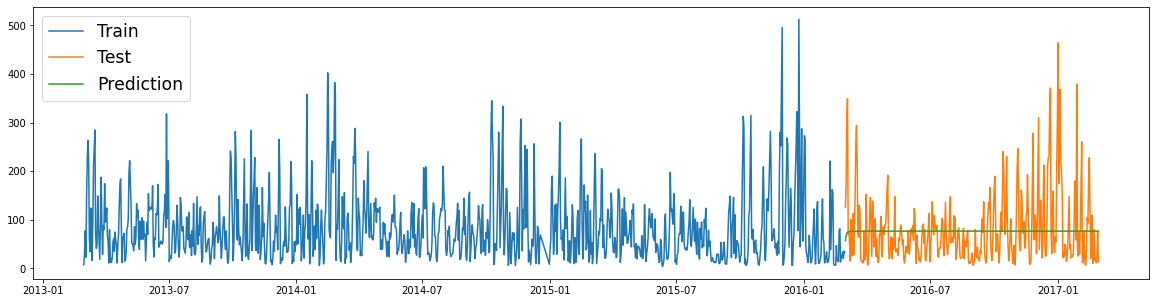

            Predictions
Date-Time              
2016-03-01    56.991410
2016-03-02    67.037313
2016-03-03    72.017601
2016-03-04    74.400078
2016-03-05    75.439550
...                 ...
2017-02-24    76.559427
2017-02-25    76.559427
2017-02-26    76.559427
2017-02-27    76.559427
2017-02-28    76.559427

[365 rows x 1 columns]


In [10]:
# Predict PM2.5 using LSTM
predictions = predict_LSTM(scaled_train_PM25, scaler, train_PM25, test_PM25,time_steps, n_feature, model)
print(predictions)

In [14]:
# Plot the predictions for PM2.5 pollutant
evaluate_LSTM(test_PM25, predictions)


Evaluation of  PM2.5
The Mean Squared Error of the forecasts is 5286.5241
The Mean Absolute Error of the forecasts is 51.1608
The Root Mean Squared Error of the forecasts is 72.7085

Results for PM2.5 successfully saved to result/lstm.csv


In [15]:
# load all monthly datasets
train_PM25 = pd.read_csv('dataset/monthly/train/train_PM2.5.csv', parse_dates = [0], index_col = [0])
test_PM25 = pd.read_csv('dataset/monthly/test/test_PM2.5.csv', parse_dates = [0], index_col = [0])
train_PM10 = pd.read_csv('dataset/monthly/train/train_PM10.csv', parse_dates = [0], index_col = [0])
test_PM10 = pd.read_csv('dataset/monthly/test/test_PM10.csv', parse_dates = [0], index_col = [0])
train_SO2 = pd.read_csv('dataset/monthly/train/train_SO2.csv', parse_dates = [0], index_col = [0])
test_SO2 = pd.read_csv('dataset/monthly/test/test_SO2.csv', parse_dates = [0], index_col = [0])
train_NO2 = pd.read_csv('dataset/monthly/train/train_NO2.csv', parse_dates = [0], index_col = [0])
test_NO2 = pd.read_csv('dataset/monthly/test/test_NO2.csv', parse_dates = [0], index_col = [0])
train_CO = pd.read_csv('dataset/monthly/train/train_CO.csv', parse_dates = [0], index_col = [0])
test_CO = pd.read_csv('dataset/monthly/test/test_CO.csv', parse_dates = [0], index_col = [0])
train_O3 = pd.read_csv('dataset/monthly/train/train_O3.csv', parse_dates = [0], index_col = [0])
test_O3 = pd.read_csv('dataset/monthly/test/test_O3.csv', parse_dates = [0], index_col = [0])

In [16]:
# apply transformations on all monthly data
scaled_train_PM25, scaler_PM25 = transform_data(train_PM25)
scaled_train_PM10, scaler_PM10 = transform_data(train_PM10)
scaled_train_SO2, scaler_SO2 = transform_data(train_SO2)
scaled_train_NO2, scaler_NO2 = transform_data(train_NO2)
scaled_train_CO, scaler_CO = transform_data(train_CO)
scaled_train_O3, scaler_O3 = transform_data(train_O3)

In [17]:
# define parameters for the LSTM model (After some manual hyperparameter tuning)
time_steps = 12
n_feature = 1
epochs = 350
# create list for test data
list_test = [test_PM25, test_PM10, test_SO2, test_NO2, test_CO, test_O3]
# create list for train data
list_train = [train_PM25, train_PM10, train_SO2, train_NO2, train_CO, train_O3]
# create list for scaled train data
list_scaled_train = [scaled_train_PM25, scaled_train_PM10, scaled_train_SO2, scaled_train_NO2, scaled_train_CO, scaled_train_O3]
# create list of all scalers
list_scaler = [scaler_PM25, scaler_PM10, scaler_SO2, scaler_NO2, scaler_CO, scaler_O3]
# create list for storing models
list_models = []
# fit LSTM model to all the data
for i in range(len(list_scaled_train)):
    print('\nFitting LSTM on ',list_train[i].columns.values[0])
    list_models.append(fit_LSTM(list_scaled_train[i], time_steps, n_feature, epochs = epochs))


Fitting LSTM on  PM2.5
Epoch 1/350


/home/mahad/.local/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


4/4 [==============================] - 1s 15ms/step - loss: 0.1301
Epoch 2/350
4/4 [==============================] - 0s 17ms/step - loss: 0.0663
Epoch 3/350
4/4 [==============================] - 0s 14ms/step - loss: 0.0606
Epoch 4/350
4/4 [==============================] - 0s 14ms/step - loss: 0.0925
Epoch 5/350
4/4 [==============================] - 0s 15ms/step - loss: 0.0454
Epoch 6/350
4/4 [==============================] - 0s 15ms/step - loss: 0.0476
Epoch 7/350
4/4 [==============================] - 0s 14ms/step - loss: 0.0549
Epoch 8/350
4/4 [==============================] - 0s 19ms/step - loss: 0.0677
Epoch 9/350
4/4 [==============================] - 0s 17ms/step - loss: 0.0495
Epoch 10/350
4/4 [==============================] - 0s 18ms/step - loss: 0.0392
Epoch 11/350
4/4 [==============================] - 0s 19ms/step - loss: 0.0745
Epoch 12/350
4/4 [==============================] - 0s 18ms/step - loss: 0.0546
Epoch 13/350
4/4 [==============================] - 0s 19ms/s


Predictions of  PM2.5


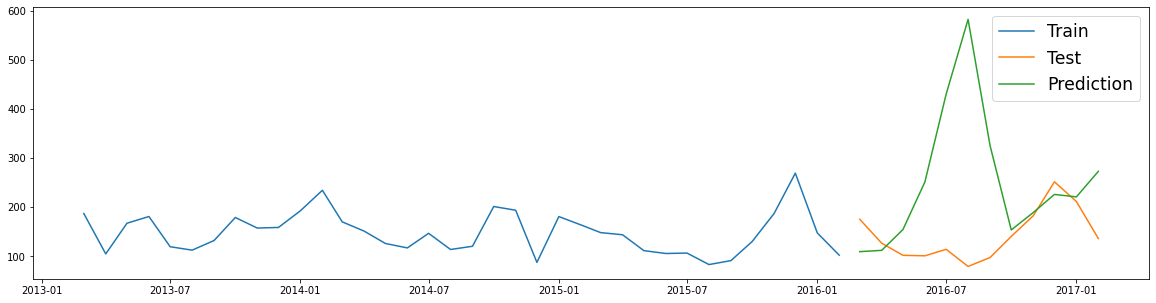


Predictions of  PM10


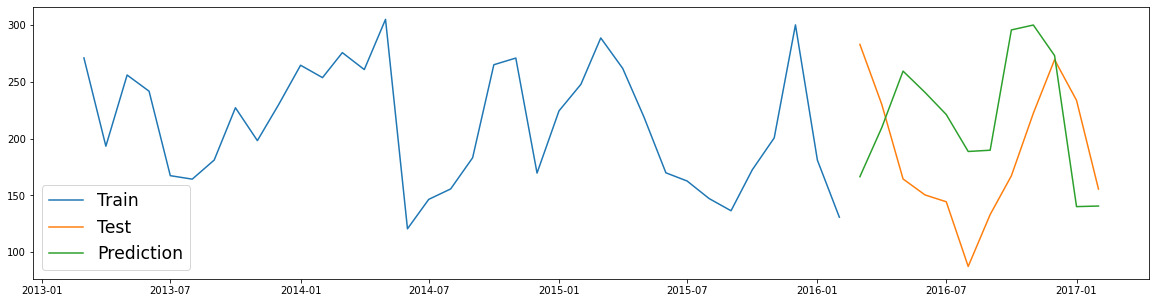


Predictions of  SO2


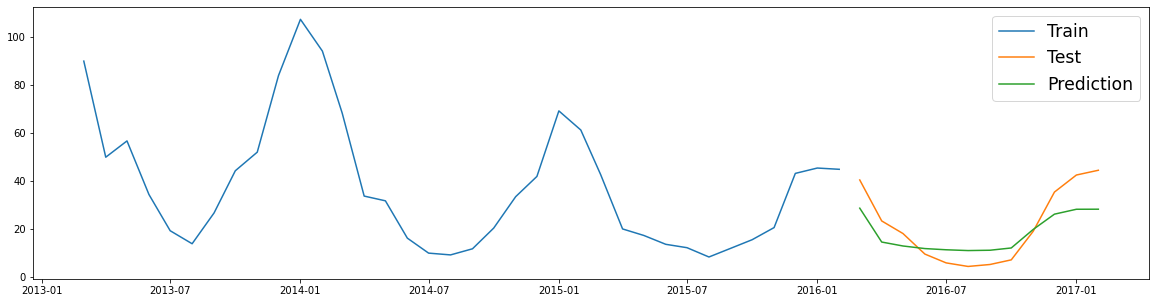


Predictions of  NO2


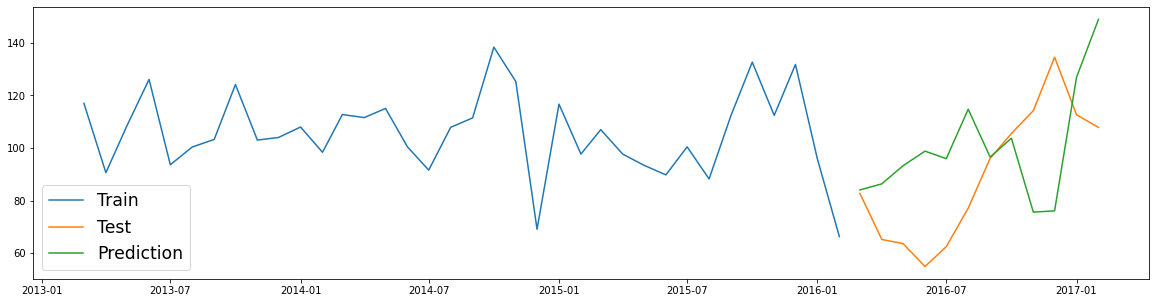


Predictions of  CO


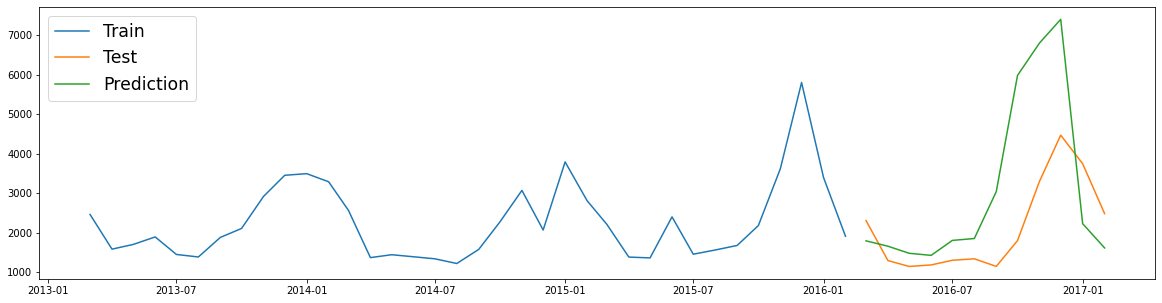


Predictions of  O3


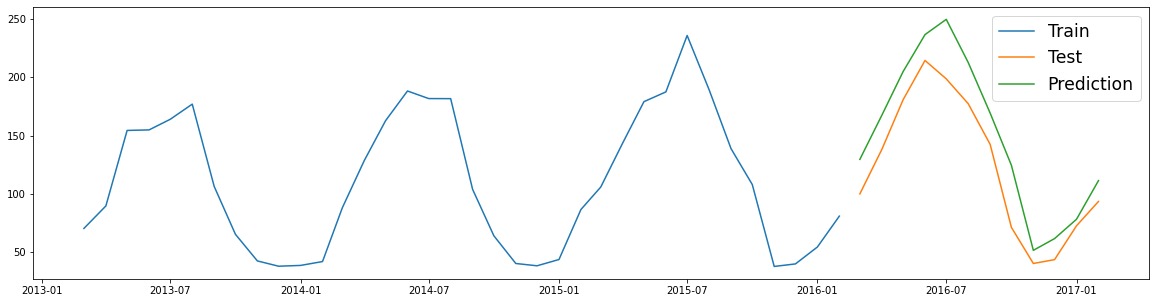

In [18]:
# Predict all the pollutants
list_predictions = [predict_LSTM(list_scaled_train[i], list_scaler[i],\
                                list_train[i], list_test[i],time_steps,\
                                n_feature, list_models[i]) \
                   for i in range(len(list_scaled_train))]


In [19]:
# Evaluate all the models
for i in range(len(list_predictions)):
    # Evaluate each model
    evaluate_LSTM(list_test[i], list_predictions[i])


Evaluation of  PM2.5
The Mean Squared Error of the forecasts is 37956.7503
The Mean Absolute Error of the forecasts is 126.9782
The Root Mean Squared Error of the forecasts is 194.8249

Results for PM2.5 successfully saved to result/lstm.csv

Evaluation of  PM10
The Mean Squared Error of the forecasts is 6831.1071
The Mean Absolute Error of the forecasts is 72.8878
The Root Mean Squared Error of the forecasts is 82.6505

Results for PM10 successfully saved to result/lstm.csv

Evaluation of  SO2
The Mean Squared Error of the forecasts is 77.6492
The Mean Absolute Error of the forecasts is 7.6168
The Root Mean Squared Error of the forecasts is 8.8119

Results for SO2 successfully saved to result/lstm.csv

Evaluation of  NO2
The Mean Squared Error of the forecasts is 1048.9402
The Mean Absolute Error of the forecasts is 26.8046
The Root Mean Squared Error of the forecasts is 32.3873

Results for NO2 successfully saved to result/lstm.csv

Evaluation of  CO
The Mean Squared Error of the fo